# Sentiment Analysis Using Daily News for Stock Market Prediction
## Using 8 years daily news headlines to predict stock market movement (from Kaggle)

https://www.kaggle.com/aaron7sun/stocknews

## Methods used:

### * Logistic Regresstion
### * Elastic Net

### Loading packages

In [26]:
options(warn=-1)
if(!require(data.table)) install.packages('data.table')
if(!require(tm)) install.packages('tm')
if(!require(glmnet)) install.packages('glmnet')
if(!require(ggplot2)) install.packages('ggplot2')
if(!require(pROC)) install.packages('pROC')
if(!require(SnowballC)) install.packages('SnowballC')
if(!require(wordcloud)) install.packages('wordcloud')
if(!require(ROCR)) install.packages('ROCR')
if(!require(stargazer)) install.packages('stargazer')
if(!require(sandwich)) install.packages('sandwich')
if(!require(lmtest)) install.packages('lmtest')
if(!require(dplyr)) install.packages('dplyr')

### Data loading (news data csv)

In [4]:
data <- read.csv("DJIA_Headline_News.csv", stringsAsFactors = FALSE)

In [5]:
head(data, 2)

Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as countries move to brink of war""",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)',"b'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire'","b""Afghan children raped with 'impunity,' U.N. official says - this is sick, a three year old was raped and they do nothing""",b'150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.',"b""Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO's side""","b""The 'enemy combatent' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it.""",...,"b'Georgia Invades South Ossetia - if Russia gets involved, will NATO absorb Georgia and unleash a full scale war?'",b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to prevent an Israeli strike on Iran."" Israeli Defense Minister Ehud Barak: ""Israel is prepared for uncompromising victory in the case of military hostilities.""'",b'This is a busy day: The European Union has approved new sanctions against Iran in protest at its nuclear programme.',"b""Georgia will withdraw 1,000 soldiers from Iraq to help fight off Russian forces in Georgia's breakaway region of South Ossetia""",b'Why the Pentagon Thinks Attacking Iran is a Bad Idea - US News &amp; World Report',b'Caucasus in crisis: Georgia invades South Ossetia',"b'Indian shoe manufactory - And again in a series of ""you do not like your work?""'",b'Visitors Suffering from Mental Illnesses Banned from Olympics',"b""No Help for Mexico's Kidnapping Surge"""
2008-08-11,1,"b'Why wont America and Nato help us? If they wont help us now, why did we help them in Iraq?'",b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli training, we're fending off Russia """,b'Georgian army flees in disarray as Russians advance - Gori abandoned to Russia without a shot fired',"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zealand Passports doing in Iraq?',b'Russia angered by Israeli military sale to Georgia',b'An American citizen living in S.Ossetia blames U.S. and Georgian leaders for the genocide of innocent people',...,b'Israel and the US behind the Georgian aggression?',"b'""Do not believe TV, neither Russian nor Georgian. There are much more victims""'",b'Riots are still going on in Montreal (Canada) because police murdered a boy on Saturday.',b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Torture',b' Russia has just beaten the United States over the head with Peak Oil',b'Perhaps *the* question about the Georgia - Russia conflict ',b'Russia is so much better at war',"b""So this is what it's come to: trading sex for food."""


### Pre-processing and data cleaning

In [6]:
data$Date <- as.Date(data$Date)

### Combine headlines into one text blob for each day and add sentence separation token

In [7]:
data$all <- paste(data$Top1, data$Top2, data$Top3, data$Top4, data$Top5, data$Top6,
            data$Top7, data$Top8, data$Top9, data$Top10, data$Top11, data$Top12, data$Top13,
            data$Top14, data$Top15, data$Top16, data$Top17, data$Top18, data$Top19,
            data$Top20, data$Top21, data$Top22, data$Top23, data$Top24, data$Top25,
            sep = " <s> ")

### Getting rid of b's and backslashes

In [8]:
data$all <- gsub("b\"|b'|\\\\|\\\"", "", data$all)

### Getting rid of all punctuation except headline separators

In [9]:
data$all <- gsub("([<>])|[[:punct:]]", "\\1", data$all)

In [10]:
data <- data[, c("Date", "Label", "all")]

In [11]:
head(data, 2)

Date,Label,all
2008-08-08,0,Georgia downs two Russian warplanes as countries move to brink of war <s> BREAKING Musharraf to be impeached <s> Russia Today Columns of troops roll into South Ossetia footage from fighting YouTube <s> Russian tanks are moving towards the capital of South Ossetia which has reportedly been completely destroyed by Georgian artillery fire <s> Afghan children raped with impunity UN official says this is sick a three year old was raped and they do nothing <s> 150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets <s> Breaking Georgia invades South Ossetia Russia warned it would intervene on SOs side <s> The enemy combatent trials are nothing but a sham Salim Haman has been sentenced to 5 12 years but will be kept longer anyway just because they feel like it <s> Georgian troops retreat from S Osettain capital presumably leaving several hundred people killed VIDEO <s> Did the US Prep Georgia for War with Russia <s> Rice Gives Green Light for Israel to Attack Iran Says US has no veto over Israeli military ops <s> AnnouncingClass Action Lawsuit on Behalf of American Public Against the FBI <s> SoRussia and Georgia are at war and the NYTs top story is opening ceremonies of the Olympics What a fucking disgrace and yet further proof of the decline of journalism <s> China tells Bush to stay out of other countries affairs <s> Did World War III start today <s> Georgia Invades South Ossetia if Russia gets involved will NATO absorb Georgia and unleash a full scale war <s> AlQaeda Faces Islamist Backlash <s> Condoleezza Rice The US would not act to prevent an Israeli strike on Iran Israeli Defense Minister Ehud Barak Israel is prepared for uncompromising victory in the case of military hostilities <s> This is a busy day The European Union has approved new sanctions against Iran in protest at its nuclear programme <s> Georgia will withdraw 1000 soldiers from Iraq to help fight off Russian forces in Georgias breakaway region of South Ossetia <s> Why the Pentagon Thinks Attacking Iran is a Bad Idea US News amp World Report <s> Caucasus in crisis Georgia invades South Ossetia <s> Indian shoe manufactory And again in a series of you do not like your work <s> Visitors Suffering from Mental Illnesses Banned from Olympics <s> No Help for Mexicos Kidnapping Surge
2008-08-11,1,Why wont America and Nato help us If they wont help us now why did we help them in Iraq <s> Bush puts foot down on Georgian conflict <s> Jewish Georgian minister Thanks to Israeli training were fending off Russia <s> Georgian army flees in disarray as Russians advance Gori abandoned to Russia without a shot fired <s> Olympic opening ceremony fireworks faked <s> What were the Mossad with fraudulent New Zealand Passports doing in Iraq <s> Russia angered by Israeli military sale to Georgia <s> An American citizen living in SOssetia blames US and Georgian leaders for the genocide of innocent people <s> Welcome To World War IV Now In High Definition <s> Georgias move a mistake of monumental proportions <s> Russia presses deeper into Georgia US says regime change is goal <s> Abhinav Bindra wins first ever Individual Olympic Gold Medal for India <s> US ship heads for Arctic to define territory <s> Drivers in a Jerusalem taxi station threaten to quit rather than work for their new boss an Ara <s> The French Team is Stunned by Phelps and the 4x100m Relay Team <s> Israel and the US behind the Georgian aggression <s> Do not believe TV neither Russian nor Georgian There are much more victims <s> Riots are still going on in Montreal Canada because police murdered a boy on Saturday <s> China to overtake US as largest manufacturer <s> War in South Ossetia PICS <s> Israeli Physicians Group Condemns State Torture <s> Russia has just beaten the United States over the head with Peak Oil <s> Perhaps the question about the Georgia Russia conflict <s> Russia is so much better at war <s> So this is what its come to trading sex for food


### Using (VectorSource(data)) to load the corpus. now each document corresponds to a different date in the dataset

In [12]:
Corpus <- Corpus(VectorSource(data$all))

### Removing Punctuations,  numbers, making all lower case, removing stopwords and stemming

In [13]:
options(warn=-1)
Corpus = tm_map(Corpus, removePunctuation)
Corpus = tm_map(Corpus, content_transformer(gsub), pattern = "\t", replacement = " ")
Corpus = tm_map(Corpus, content_transformer(gsub), pattern = "[^a-zA-Z0-9 ]",
replacement = " ")
Corpus <- tm_map(Corpus, removeNumbers)
Corpus <- tm_map(Corpus, tolower)
Corpus <- tm_map(Corpus, removeWords, c(stopwords(kind = "SMART"), "<s>"))
Corpus <- tm_map(Corpus, stripWhitespace)

### Creating DocumentTermMatrix

In [14]:
control <- list(
    removeNumbers = TRUE,
    tolower = TRUE,
    stopwords = c(stopwords(kind = 'SMART'), '<s>'), # exclude stopwords and headline tokens
    stemming = TRUE
)

dtm <- Corpus %>% DocumentTermMatrix(control=control)
inspect(dtm[5:10, 801:810])

<<DocumentTermMatrix (documents: 6, terms: 10)>>
Non-/sparse entries: 0/60
Sparsity           : 100%
Maximal term length: 17
Weighting          : term frequency (tf)
Sample             :
    Terms
Docs americanseuropean americansnn americansourc americanstyl americantrain
  5                  0           0             0            0             0
  6                  0           0             0            0             0
  7                  0           0             0            0             0
  8                  0           0             0            0             0
  9                  0           0             0            0             0
  10                 0           0             0            0             0
    Terms
Docs americanturkish americath amerium ami amia
  5                0         0       0   0    0
  6                0         0       0   0    0
  7                0         0       0   0    0
  8                0         0       0   0    0
  9                0 

### Creating a freq matrix as the column sums of Docuement Term Matrix

In [15]:
# Organizing words by frequency
freq <- colSums(as.matrix(dtm))
ord_corpus <- order(freq)

# Most common words
freq[tail(ord_corpus)]

israel  china govern  world   year   kill 
  2161   2195   2197   2432   2594   2666

In [16]:
word_freq <- data.table(word = names(freq), freq = freq)

### Plot of most frequent words

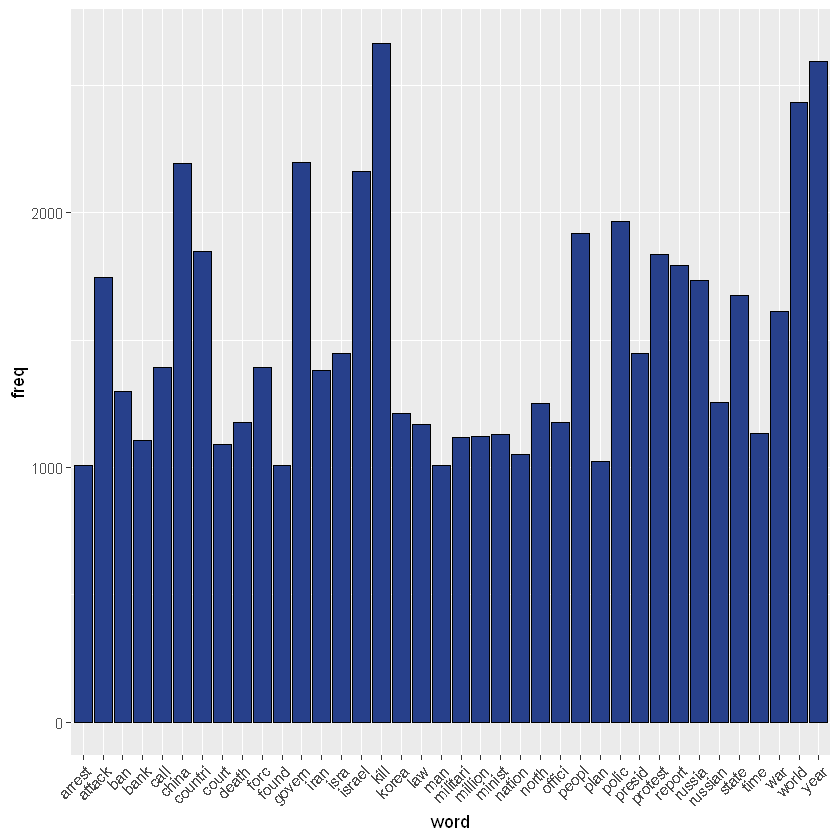

In [17]:
ggplot(word_freq[freq > 1000], aes(word, freq)) + geom_bar(fill = "royalblue4",
color = "black", stat = "identity") + theme(axis.text.x = element_text(angle = 45,
hjust = 1))

### Word cloud : 100 most frequent words

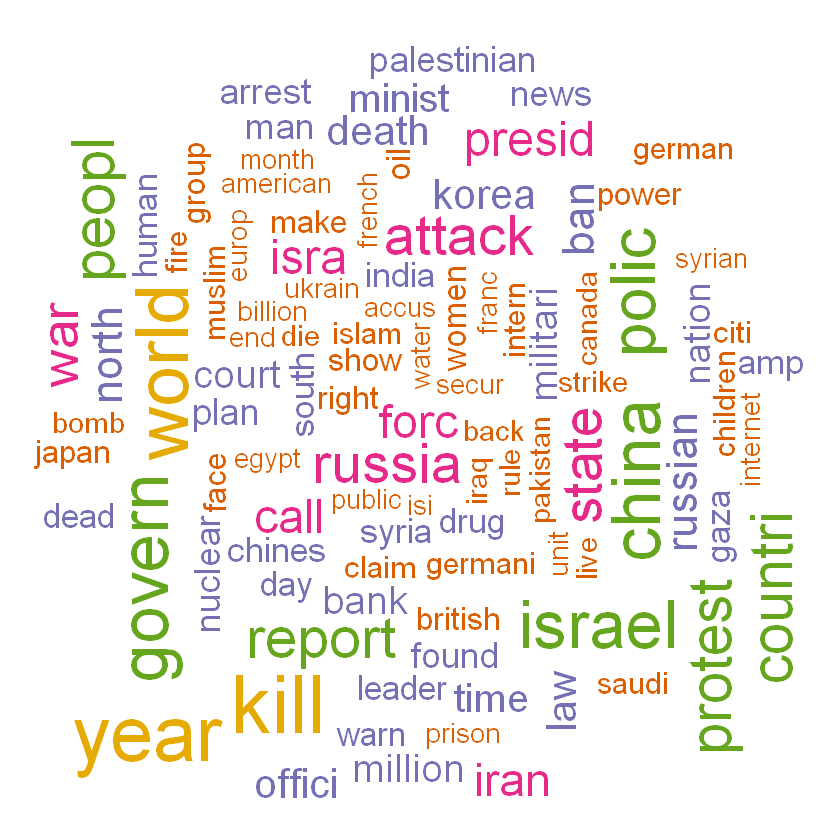

In [18]:
wordcloud(names(freq), freq, max.words = 100, rot.per = 0.3, colors = brewer.pal(6,
"Dark2"))

### Creating full dataset

In [19]:
y_data <- as.factor(data$Label)
x_data <- as.matrix(dtm)
data_full <- data

### Y variable :: 1 if the Dow Jones goes up or stays the same during that day and 0 otherwise.

In [20]:
head(y_data)

[1] 0 1 0 0 1 1
Levels: 0 1

### X variable :: 25 news headlines on each day 

### Spliting training and test set data
Training data from 2008 to 2014
<br>Test data from 2015 to 2018

In [21]:
split_index <- data$Date <= as.Date("2014-12-31")
data_train <- data_full[split_index, ]
y_train <- as.factor(data$Label[split_index])

In [22]:
data_test <- data_full[!split_index, ]
y_test <- as.factor(data$Label[!split_index])

### Sentiment index based on words likely to matter for the stock market.

In [23]:
sentiment_words <- c("invest", "growth", "grow", "high", "strong", "lead", "bankrupt", 
                     "good", "bull", "bear", "interest", "market", "hous", "rate", "oil", "loss",
                     "weak", "low", "fear", "poor", "risk", "stock", "debt", "financi", "fiscal",
                     "reserv", "crash", "war", "recess")

dtm_sentiment <- dtm[, sentiment_words]
x_data_sent <- as.matrix(dtm_sentiment)

In [24]:
setkey(word_freq, freq)
word_freq[word %in% sentiment_words]

word,freq
bull,12
fiscal,12
bankrupt,23
weak,30
recess,78
growth,88
bear,93
stock,111
loss,113
strong,113


### Word with frequency > 1000 is war. The other most frequent word is oil (freq = 857), high (freq = 436), fear (freq = 423) and so on

### Fitting logistic regression model to the y_data (Dow Jones Up or same vs down) vs the data in dtm_sentiment (based on 25 news headlines)

In [25]:
glm.fit <- glm(y_data ~ x_data_sent, family = "binomial")
summary(glm.fit)


Call:
glm(formula = y_data ~ x_data_sent, family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6573  -1.2365   0.9617   1.0925   1.8276  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          0.229378   0.089433   2.565 0.010323 *  
x_data_sentinvest   -0.180426   0.172342  -1.047 0.295143    
x_data_sentgrowth    0.256280   0.211696   1.211 0.226046    
x_data_sentgrow     -0.032557   0.109809  -0.296 0.766855    
x_data_senthigh      0.099427   0.097311   1.022 0.306905    
x_data_sentstrong   -0.240696   0.190047  -1.267 0.205331    
x_data_sentlead      0.022544   0.105989   0.213 0.831561    
x_data_sentbankrupt -0.561593   0.437678  -1.283 0.199451    
x_data_sentgood     -0.023833   0.125785  -0.189 0.849724    
x_data_sentbull     -0.172888   0.588551  -0.294 0.768948    
x_data_sentbear      0.301502   0.197119   1.530 0.126129    
x_data_sentinterest -0.223533   0.146046  -1.531 0.125877    
x

### intercept and the coefficients on low and stock appears significant

### ROC curve for this model

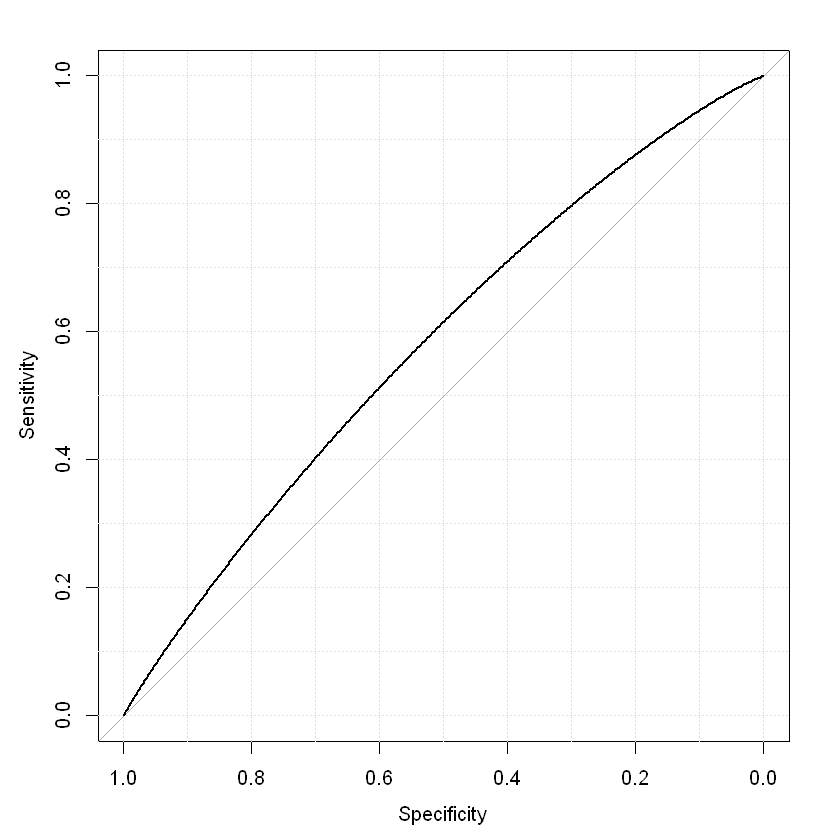

In [29]:
ROC_enet <- roc(response = y_data, predictor = preds_logit, smooth = TRUE, plot = TRUE, grid = TRUE)

### Manually plotting ROC curve

In [41]:
simple_roc <- function(labels, scores) {
        labels <- labels[order(scores, decreasing = TRUE)]
        data.frame(TPR = cumsum(labels)/sum(labels), FPR = cumsum(!labels)/sum(!labels), labels)
}

In [42]:
glm_roc <- simple_roc(y_data == "1", preds_logit)
TPR1 <- glm_roc$TPR

FPR1 <- glm_roc$FPR
data1 <- data.table(TPR = TPR1, FPR = FPR1)

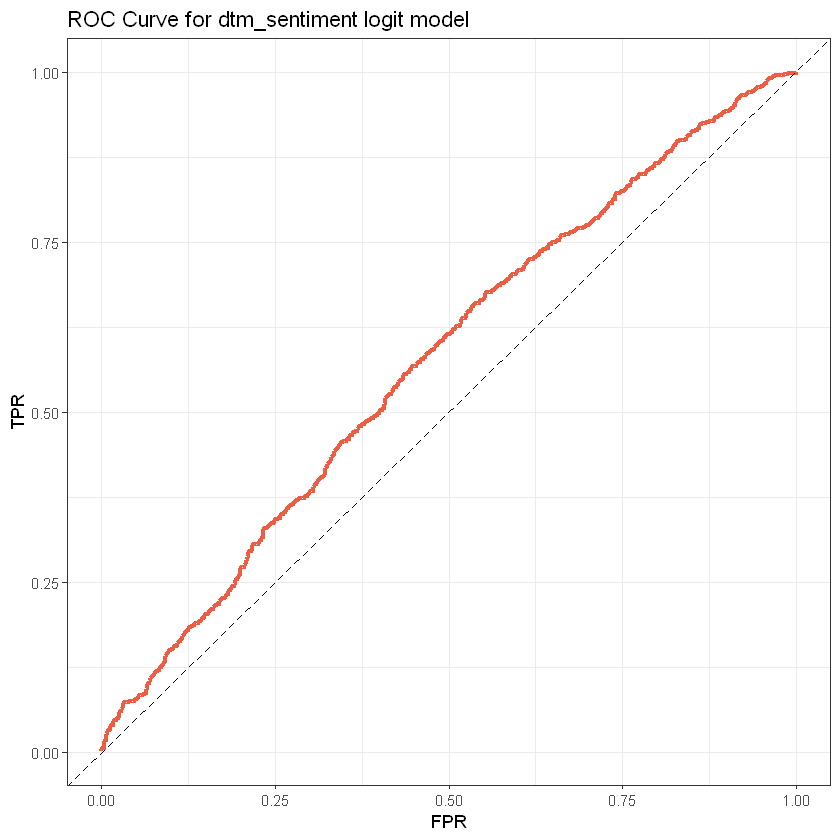

In [43]:
ggplot(data1, aes(x = FPR, y = TPR)) + geom_line(color = "tomato2", size = 1.2) +
ggtitle("ROC Curve for dtm_sentiment logit model") + geom_abline(slope = 1,
intercept = 0, linetype = "longdash") + theme_bw()

### Model is better than random (the 45-degree line)

## fitting an elastic net model with alpha = 0.5 using cross-validation

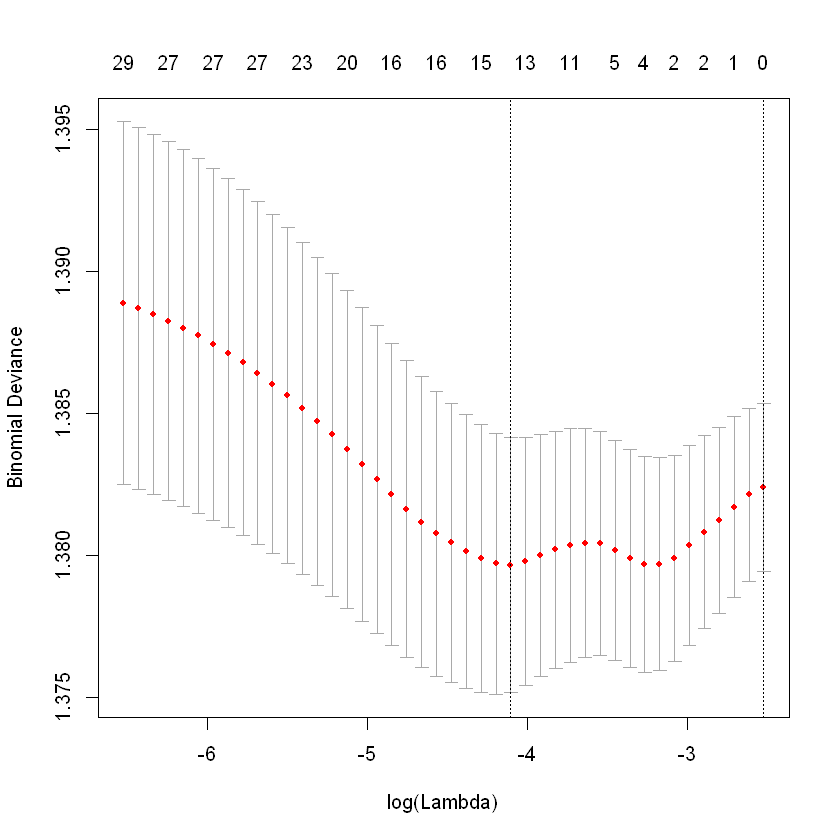

In [45]:
glmnet.fit <- cv.glmnet(x = x_data_sent, y = y_data, family = "binomial", alpha = 0.5)
plot.cv.glmnet(glmnet.fit)

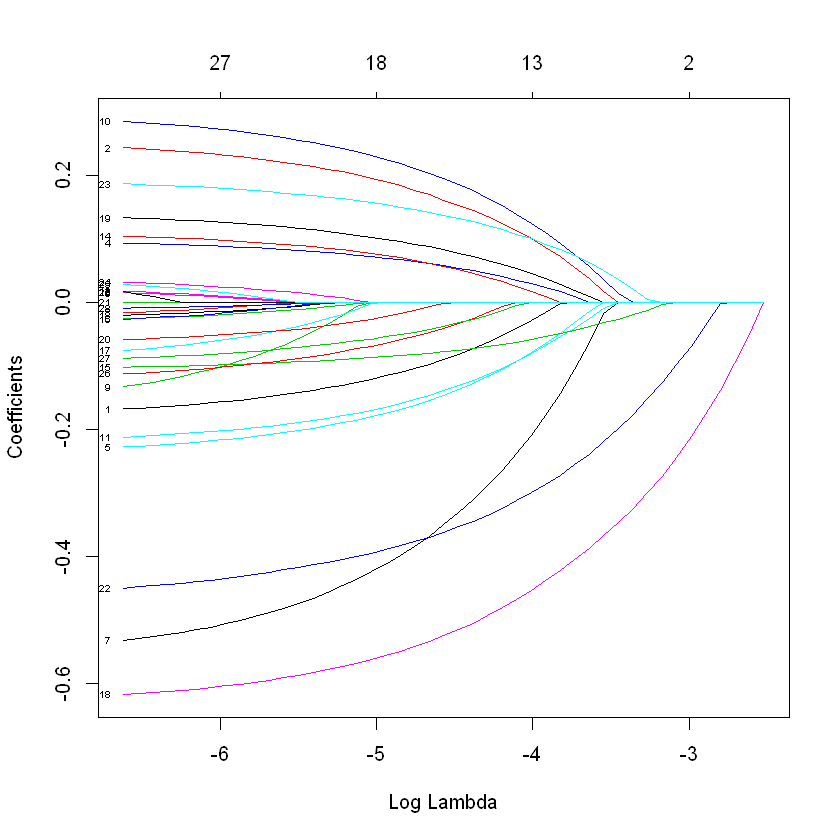

In [47]:
plot.glmnet(glmnet.fit$glmnet.fit, "lambda", label = TRUE)

### Creating ROC curve for Elastic Net model

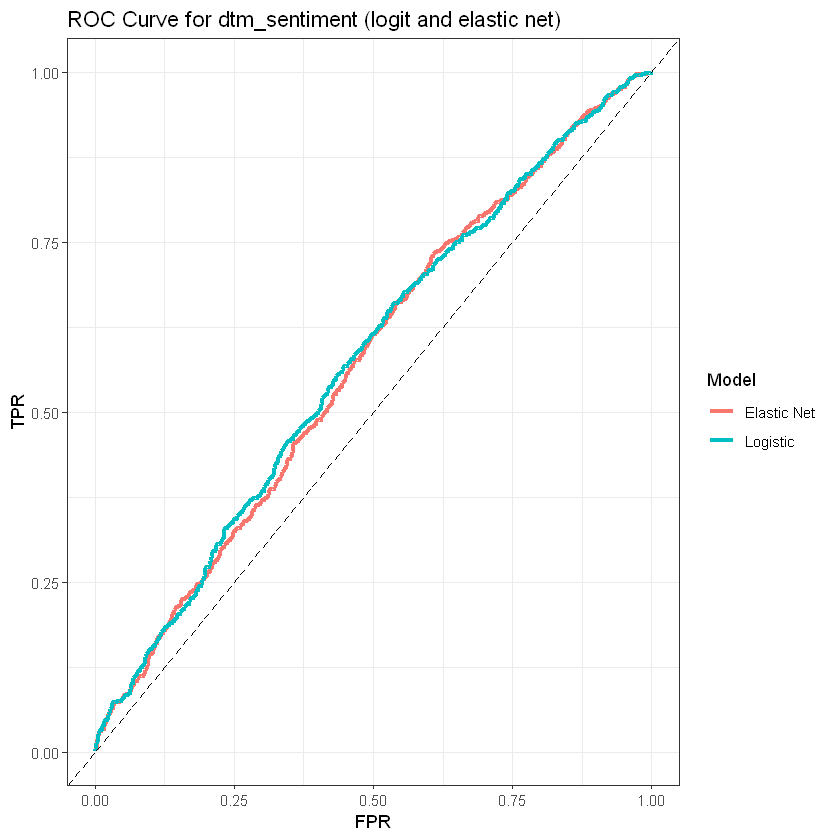

In [49]:
preds_enet <- as.numeric(predict(glmnet.fit, newx = x_data_sent, type = "response", s = "lambda.min"))
glmnet_roc <- simple_roc(y_data == "1", preds_enet)
TPR2 <- glmnet_roc$TPR
FPR2 <- glmnet_roc$FPR
data2 <- data.table(TPR = TPR2, FPR = FPR2)
data1[, `:=`(Model, "Logistic")]
data2[, `:=`(Model, "Elastic Net")]
data12 <- rbind(data1, data2)

# Plotting the corresponding ROC curve
ggplot(data12, aes(x = FPR, y = TPR, color = Model)) + geom_line(size = 1.2) +
ggtitle("ROC Curve for dtm_sentiment (logit and elastic net)") + geom_abline(slope = 1,
intercept = 0, linetype = "longdash") + theme_bw()

### From the area under the ROC curve we can see that the elastic net model performs slightly worse than the logistic model but better than the random model (45-degree line).

### Out of sample prediction using test data on logistic model

In [50]:
x_train <- x_data_sent[1:length(y_train), ]
x_test <- x_data_sent[(length(y_train) + 1):length(data_full$Date), ]

In [52]:
logit.fit_train <- glm(y_train ~ x_train, family = "binomial")
preds_logit_test <- predict(logit.fit_train, type = "response", new = data.frame(x_test))
preds_logit_test <- preds_logit_test[1:length(y_test)]
prop_correct_logit <- sum(round(preds_logit_test) == y_test)/length(y_test) # Proportion correct of out-prop_correct_logit
prop_correct_logit

[1] 0.5291005

### Out of sample prediction using test data on Elastic Net model

In [54]:
enet.fit_train <- cv.glmnet(x = x_train, y = y_train, family = "binomial", alpha = 0.5)
preds_enet_test <- predict(enet.fit_train, newx = x_test, type = "response", s = "lambda.1se")
prop_correct_enet <- sum(round(preds_enet_test) == y_test)/length(y_test) # Proportion correct of out-of-prop_correct_enet
prop_correct_enet

[1] 0.5079365

### Logistic model performs better than the elastic net model out-of-sample <br> Both perform better than random a random model (the proportions of correct predictions are above 50% for both models)

### 63 day moving average of the prediction both for predicted variable and actual value in train sample
### Running ols regression on predicted value vs actual value

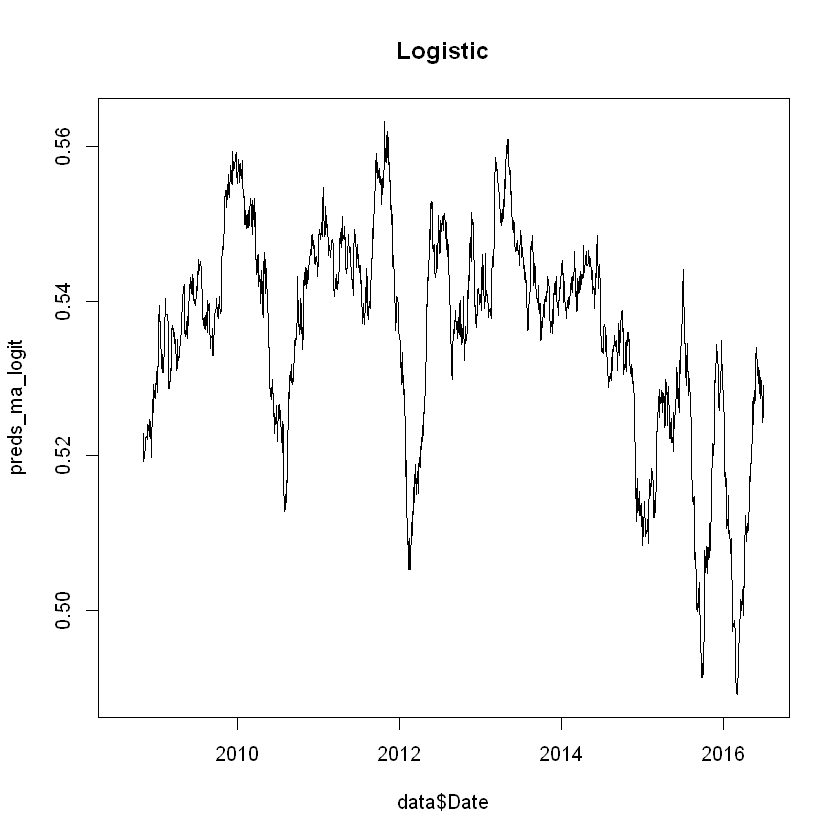

In [55]:
f63 <- rep(1/63, 63)
preds_ma_logit <- stats::filter(preds_logit, f63, sides = 1)
preds_ma_enet <- stats::filter(preds_enet, f63, sides = 1)
y_ma <- stats::filter(y_data, f63, sides = 1)
plot(data$Date, preds_ma_logit, type = "l", main = "Logistic")

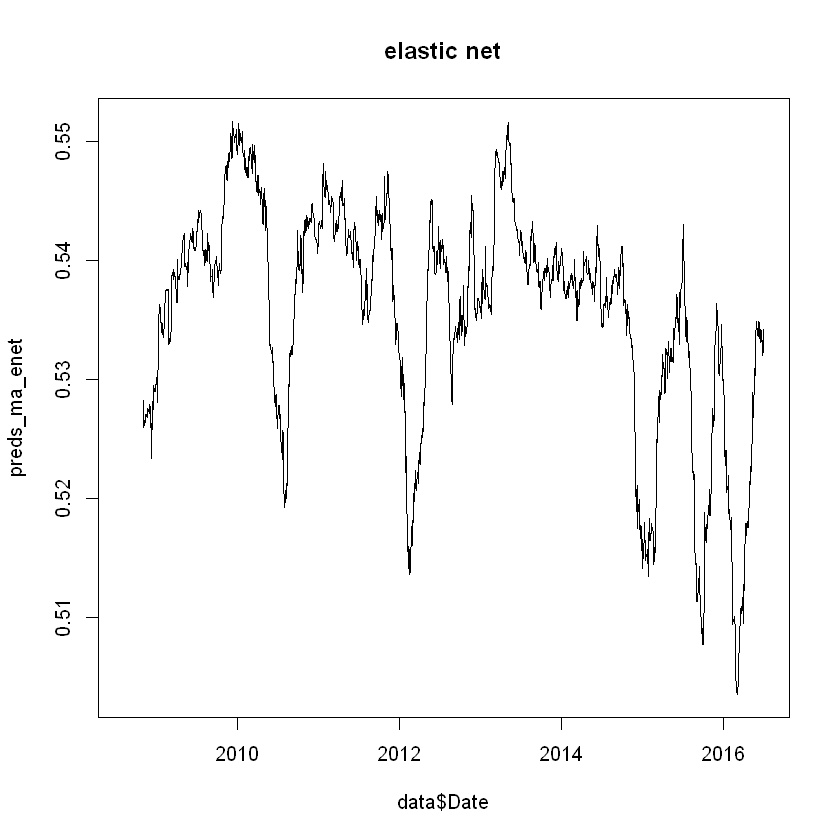

In [56]:
plot(data$Date, preds_ma_enet, type = "l", main = "elastic net")

### Running three ols regression
    1. Actual Market movement (1/0) vs predicted value
    2. 63 days moving average of actual vs predicted_value
    3. With Newwy-West lag to correct overlapping error due to moving average

In [57]:
NW_lag = 90
# Comparison for logistic
reg1 <- lm(as.numeric(y_data[-(1:62)]) ~ preds_logit[-(1:62)])
reg2 <- lm(as.numeric(y_ma) ~ preds_ma_logit)
stargazer(reg1, reg2, coeftest(reg2, NeweyWest(reg2, lag = NW_lag)), type = "text",
column.labels = c("OLS", "MA", "MA with NW SEs"), dep.var.labels.include = F)


                                        Dependent variable:        
                                -----------------------------------
                                   OLS       OLS      coefficient  
                                                          test     
                                   OLS        MA     MA with NW SEs
                                   (1)       (2)          (3)      
-------------------------------------------------------------------
preds_logit[-(1:62)]            1.008***                           
                                 (0.155)                           
                                                                   
preds_ma_logit                             1.487***     1.487**    
                                           (0.094)      (0.710)    
                                                                   
Constant                        0.998***   0.740***      0.740*    
                                 (0.084)   (0.0

### Comparison for elastic net

In [59]:
reg3 <- lm(as.numeric(y_data[-(1:62)]) ~ preds_enet[-(1:62)])
reg4 <- lm(as.numeric(y_ma) ~ preds_ma_enet)
stargazer(reg3, reg4, coeftest(reg4, NeweyWest(reg4, lag = NW_lag)), type = "text",
column.labels = c("OLS", "MA", "MA with NW SEs"), dep.var.labels.include = F)


                                        Dependent variable:        
                                -----------------------------------
                                   OLS       OLS      coefficient  
                                                          test     
                                   OLS        MA     MA with NW SEs
                                   (1)       (2)          (3)      
-------------------------------------------------------------------
preds_enet[-(1:62)]             1.551***                           
                                 (0.257)                           
                                                                   
preds_ma_enet                              2.489***     2.489**    
                                           (0.136)      (1.169)    
                                                                   
Constant                        0.707***   0.203***      0.203     
                                 (0.138)   (0.0


### * Coefficient are weaker after Newey West error correction because in moving average  <br> we have 62 days overlap and hence positive autocorrelations in error terms